# Transformée de Fourier rapide et convolution rapide

L'objectif de ce TP est d'explorer et les différents algorithmes utilisés en pratique pour calculer la transformée de Fourier rapide d'un signal et le produit de convolution de deux signaux.

In [1]:
# Imports 
from math import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

Dans la portion de code qui suit, on commence par définir deux signaux quelconques $f$ et $g$ de taille $N = 256$. On considérera ici des signaux correspondant à une combinaison linéaire d'un petit nombre de fonctions oscillantes.

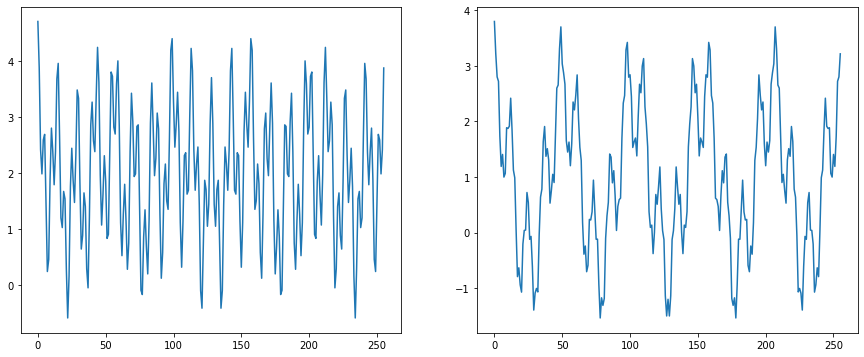

In [2]:
# Defines two signals f and g 
N = 256
t = np.arange(N)
f = 2. + 0.5*np.cos((2*pi/N)*5*t) + 1.2*np.cos((2*pi/N)*18*t) + np.cos((2*pi/N)*52*t)
g = 1. + 1.5*np.cos((2*pi/N)*5*t) + 0.3*np.cos((2*pi/N)*84*t) + np.cos((2*pi/N)*21*t)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(t, f)
ax[1].plot(t, g)
plt.show()



(1) En partant de la définition de la transformée de Fourier, implémenter un algorithme qui calcule les transformées de Fourier directe et inverse d'un signal $f$ de taille $N$. Combiens d'opérations (additions et multiplications) faut-il effectuer au cours du calcul?

**Réponse:**

Soit $f$ un signal de taille $N$. La transformée de Fourier est définie pour tout $k \in \{0, ..., N - 1\}$ par:

$$
\hat{f}[k] = \sum_{n = 0}^{N - 1} f[n] \exp \bigg (-\dfrac{i 2 \pi kn}{N} \bigg )
$$

Pour évaluer cette expression, on doit calculer un total de $N$ coefficients de Fourier. Le calcul de chaque coefficient de Fourier nécessite $N$ additions et $N$ multiplications complexes. Le nombre d'opérations à effectuer est donc $2N^2$ et croît de façon quadratique avec la taille du signal.



In [8]:
def fourier_transform(f, inverse=False):
    
    """
    Fourier transform
    
    :param f: Input signal
    :type f: numpy array
    :param inverse: If True, computes the inverse Fourier transform
    :type inverse: Boolean
    
    :return: Fourier transform of f
    :rtype: complex numpy array
    """
    N = len(f)
    n = np.arange(N)
    k = np.arange(N)
    
    k_n = k.reshape((N,1)).dot(n.reshape((1,N))) # matrice N x N
    if inverse :
        sgn = 1
        fact = 1/N
    else:
        sgn = -1
        fact = 1
        
    exp_i_n_omega_k = np.exp(sgn*2j*np.pi*k_n/N) # matrice N x N
    f_n = f.reshape((N, 1)) # vecteur N x 1
    
    f_hat = fact*exp_i_n_omega_k.dot(f_n)
    f_hat = f_hat.reshape(f.shape)
    
    return f_hat
    
    

**Comparaison avec le résultat obtenu avec la fonction de numpy pour valider le calcul:**

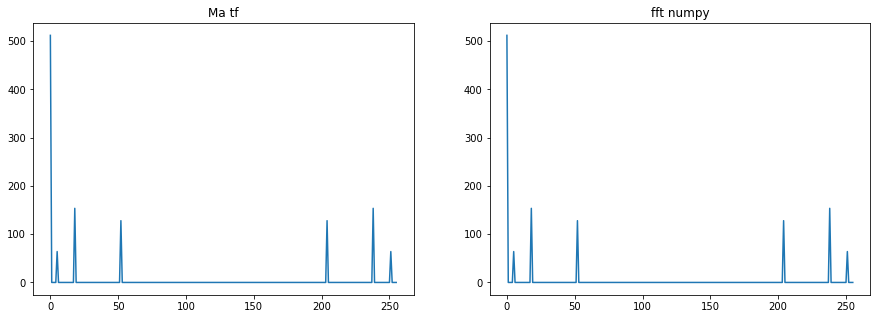

In [9]:
# Direct Fourier transform
fhat = fourier_transform(f)
fcheck = np.fft.fft(f)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.abs(fhat))
plt.title('Ma tf')
plt.subplot(1, 2, 2)
plt.plot(np.abs(fcheck))
plt.title('fft numpy')
plt.show()

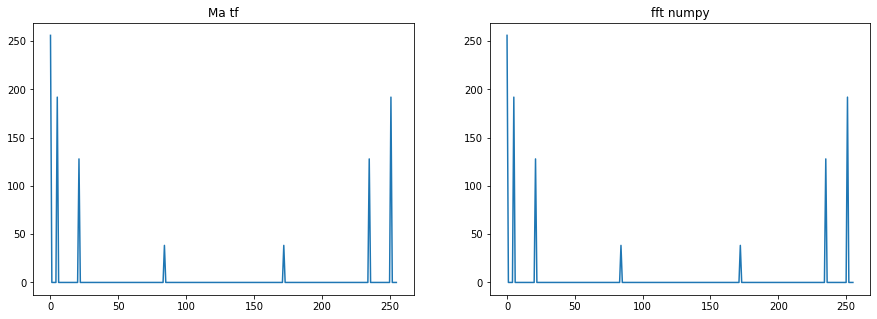

In [10]:
# Direct Fourier transform
ghat = fourier_transform(g)
gcheck = np.fft.fft(g)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(np.abs(ghat))
plt.title('Ma tf')
plt.subplot(1, 2, 2)
plt.plot(np.abs(gcheck))
plt.title('fft numpy')
plt.show()

In [6]:
# Inverse Fourier transform
frec = fourier_transform(fhat, inverse=True)
grec = fourier_transform(ghat, inverse=True)

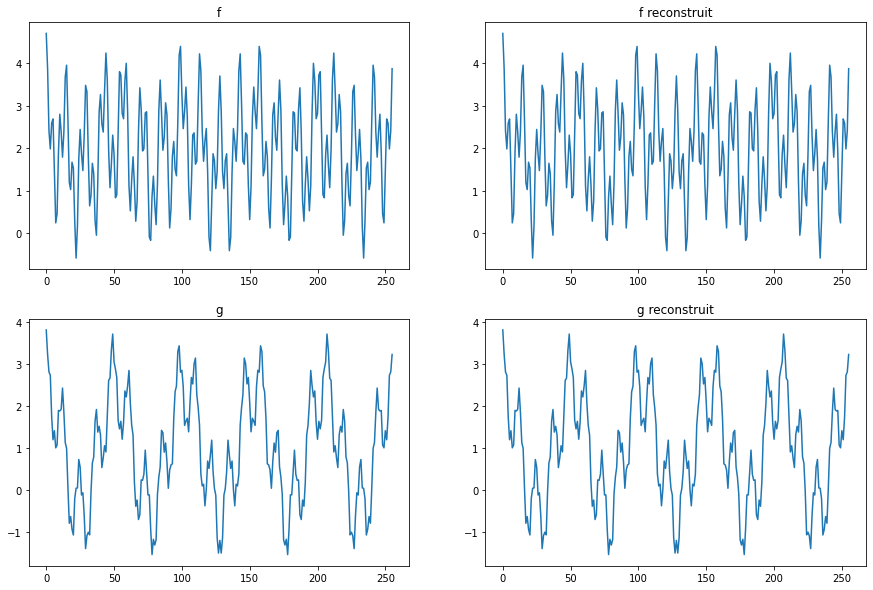

In [7]:
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.plot(f)
plt.title('f')
plt.subplot(2, 2, 2)
plt.plot(frec.real)
plt.title('f reconstruit')
plt.subplot(2, 2, 3)
plt.plot(g)
plt.title('g')
plt.subplot(2, 2, 4)
plt.plot(grec.real)
plt.title('g reconstruit')
plt.show()

(2) Soit $f$ signal de taille $N$. Dans tout ce qui suit, pour simplifier les raisonnements, on supposera que $N$ est une puissance de $2$. Montrer que pour tout entier $k$ dans $\{1, ..., N/2\}$, on vérifie:

$$
\hat{f}[2k] = \sum_{n = 0}^{N/2 - 1} (f[n] + f[n + N/2])\exp \bigg ( -i\frac{2 \pi kn}{N/2}\bigg )
$$
et
$$
\hat{f}[2k + 1] = \sum_{n = 0}^{N/2 - 1} \exp \bigg (-i\frac{2 \pi n}{N} \bigg )\bigg (f[n] - f[n + N/2]\bigg)\exp \bigg ( -i\frac{2 \pi kn}{N/2}\bigg )
$$

En déduire que la transformée de Fourier du signal $f$ de taille $N$ peut se déduire des transformées de Fourier des signaux $f_p$ et $f_q$ de tailles $N/2$, où:


$$
\forall n \in \{0, ..., N/2 - 1\}, \quad f_p[n] = f[n] + f[n + N/2])
$$

et

$$
\forall n \in \{0, ..., N/2 - 1\}, \quad f_q[n] = \exp \bigg (-i\frac{2 \pi n}{N} \bigg )(f[n] - f[n + N/2])
$$


Implémenter l'algorithme de calcul correspondant.

**Réponse:**

Par définition de la transformée de Fourier, on a

$$
\hat{f}[2k] = \sum_{n = 0}^{N} f[n]\exp \bigg ( -i\frac{2 \pi kn}{N/2}\bigg )
$$

Par ailleurs, on note que, pour tout $n \in \{0, ..., N/2 - 1\}$, on a

$$
\exp \bigg ( -i\frac{2 \pi k(n + N/2)}{N/2}\bigg ) = \exp \bigg ( -i\frac{2 \pi kn}{N/2}\bigg )
$$

On en déduit la première expression. On retrouve la seconde expression par un calcul similaire. Pour calculer la transformée de Fourier de $f$, on applique donc itérativement la procédure suivante:
1. on calcule les signaux $f_p$ et $f_q$.
2. on évalue les transformées de Fourier des signaux $f_p$ et $f_q$
3. on rassemble les coefficients de Fourier obtenus pour obtenir les coefficients de Fourier de $f$


In [11]:
def fft(f):
    
    """
    Implementation of the Fast Fourier transform algorithm
    
    :param f: Input signal
    :type f: numpy array
    
    :return: Fourier transform of f
    :rtype: numpy array
    """
    N = len(f)
    
    if N == 1:
        f_hat = f
    else:
        n = np.arange(int(N/2))
        f_hat = np.zeros(N).astype(complex)
        f_left = f[0:int(N/2)]
        f_right = f[int(N/2):N] 
        f_p = f_left + f_right
        f_q = (f_left - f_right)*np.exp(-2j*np.pi*n/N)
        f_hat[0:N:2] = fft(f_p)
        f_hat[1:N:2] = fft(f_q)
    return f_hat

**Comparaison des deux méthodes de calcul pour validation:**

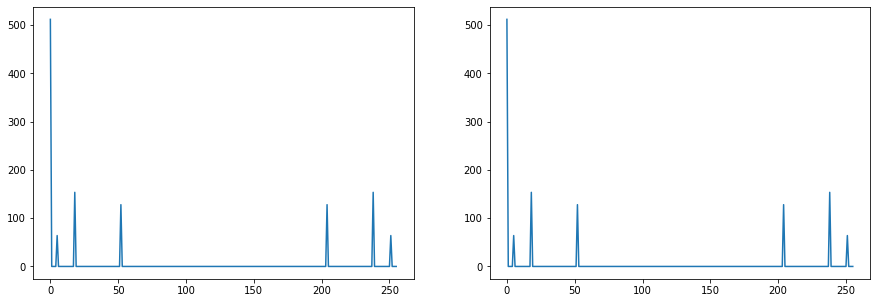

In [12]:
fhat = fft(f)
fcheck = fourier_transform(f)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(fhat.real)

plt.subplot(1, 2, 2)
plt.plot(fcheck.real)
plt.show()

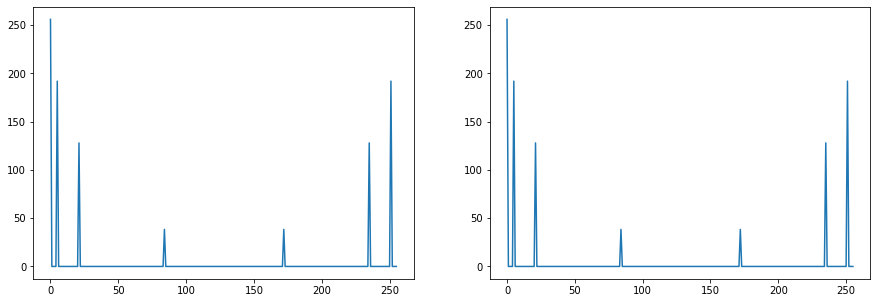

In [13]:
ghat = fft(g)
gcheck = fourier_transform(g)

plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(ghat.real)
plt.subplot(1, 2, 2)
plt.plot(gcheck.real)
plt.show()

(3) On note $f^*$ le conjugué complexe du signal $f$. Montrer que 

$$
\forall n \in \{0, ..., N - 1\}, \quad f^*[n] = \sum_{k = 0}^{N - 1} \hat{f}^*[k] \exp \bigg (-\dfrac{i 2 \pi kn}{N} \bigg ).
$$

En déduire un algorithme permettant de calculer la transformée de Fourier rapide inverse à partir de la transformée directe et implémenter cet algorithme.

In [ ]:
def ifft(fhat):
    
    """
    Implementation of the inverse fast Fourier transform
    
    :param fhat: Fourier coefficients
    :type fhat: numpy array
    
    :return: Reconstructed function
    :rtype: numpy array
    """
    N =len(fhat)
    fhat_star = np.conj(fhat)
    f_star = fft(fhat_star)/N
    f = np.conj(f_star)
    
    return f

**Validation du calcul de la transformée de Fourier inverse**

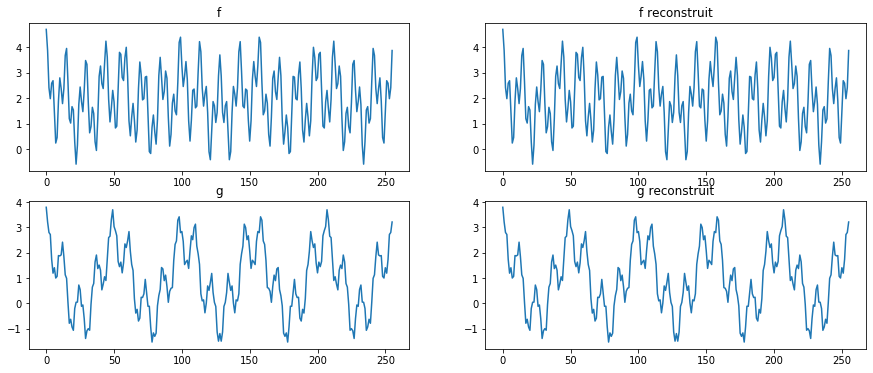

In [ ]:
frec = ifft(fhat)
grec = ifft(ghat)
plt.figure(figsize = (15, 6))
plt.subplot(2, 2, 1)
plt.title('f')
plt.plot(f)
plt.subplot(2, 2, 2)
plt.title('f reconstruit')
plt.plot(frec.real)
plt.subplot(2, 2, 3)
plt.title('g')
plt.plot(g)
plt.subplot(2, 2, 4)
plt.title('g reconstruit')
plt.plot(grec.real)
plt.show()

(4) Pour tout entier $N$, on note $C(N)$ le nombre d'opérations élémentaires requises pour calculer la transformée de Fourier d'un signal de taille $N$. En comptant le nombre d'opérations (additions et multiplications) effectuées dans l'algorithme précédent, montrer que 

$$
C(N) = 2C(N/2) + KN,
$$

où $K$ est une constante.

**Réponse:**

Dans l'algorithme précédent, l'évaluation de $f_p$ nécessite $N/2$ additions, et celle de $f_q$ $N/2$ additions et $N/2$ multiplications. Le nombre d'opérations requises est donc directement proportionnel à $3N/2$.

L'évaluation des transformées des deux transformées de Fourier requiert $2C(N/2)$ opérations élémentaires. Enfin, la recombinaison des coefficients de Fourier nécessite un nombre d'opérations élémentaires proportionnel à $N$. Il existe donc bien une constante $K$ telle que:

$$
C(N) = 2C(N/2) + KN
$$



(5) En effectuant le changement de variable $l = \log_2 (N)$ et en considérant la fonction 

$$
T(l) = \dfrac{C(2^l)}{2^l} = \dfrac{C(N)}{N},
$$

montrer que $C(N) = K N \log_2 (N)$.

**Réponse:**

On vérifie aisément que 

$$
T(l) = T(l - 1) + K, \quad \forall l \geq 1.
$$

On en déduit, en notant que $T(0) = 1$ puisque la transformée de Fourier d'un signal de taille $1$ est simplement l'identité, que $T(l) = Kl$, d'où le résultat.

# Convolution rapide

(6) Nous nous intéressons maintenant à des algorithmes permettant de calculer la convolution de deux signaux $f$ et $g$. Pour simplifier, nous supposerons dans cette section que $f$ et $g$ sont des signaux discrets de taille $M$, non nuls uniquement pour $0 \leq n < M$. On rappelle que le produit de convolution des signaux $f$ et $g$ est le signal $h$ défini par

$$
h[n] = f*g[n] = \sum_{k = - \infty}^{+ \infty }f[k]g[n - k].
$$

a. Pour quelles valeurs de $n$ a-t-on nécessairement $h[n]=0$?

b. En déduire le nombre d'opérations (additions et multiplications) nécessaires pour évaluer $h$.

c. Implémenter un algorithme calculant $h$ à partir de la formule précédente, et vérifier que le produit de convolution implémenté dans numpy (fonction numpy.convolve) permet d'obtenir le même résultat (mode: "full").

**Réponse:**

a. Le produit $f[k]g[n - k]$ peut uniquement être non nul si $0 \leq k < M$ et $0 \leq n - k < M$. On en déduit que $h[n]$ est nul si $n < 0$ ou $n \geq 2M$.

b. D'après la question précédente, le calcul de la convolution nécessite l'évaluation des quantités $h[0], ..., h[2M - 1]$ uniquement. Soit $n \in \{0, ..., 2M - 1\}$. Lorsque $n < M$, l'évaluation de $h[n]$ requiert exactement $n+1$ additions et multiplications. Lorsque $n \geq M$, l'évaluation de $h[n]$ requiert $2M - n - 1$ additions et multiplications.

Par conséquent, le nombre total d'opérations de multiplication et d'addition requises pour évaluer le produit de convolution est
$$
C(M) = 2\sum_{n = 0}^{M - 1} (n + 1) + 2\sum_{n = M}^{2M - 1}(2M - n - 1) =  2M(M - 1)
$$



In [ ]:
def convolution(f, g):
    
    """
    Convolution between two signals with same size M
    
    :param f: Signal
    :type f: numpy array
    :param g: Second signal
    :type g: numpy array
    
    :return: Convolution between f and g
    :rtype: numpy array
    """
    
    M = f.size
    h = np.zeros(2*M)

    for n in range(M):
        h[n] = 0
        for k in range(n + 1):
            h[n] += f[k]*g[n - k]
            
    for n in range(M, 2*M):
        h[n] = 0
        for k in range(n - M + 1, M):
            h[n] += f[k]*g[n - k]
    
    return h

L'implémentation de la convolution ci-dessus n'est pas forcément très efficace en faisant notamment intervenir des boucles for imbriquées. L'implémentation ci-dessous, un peu plus complexe, permet de reformuler le problème sous une forme vectorielle beaucoup plus performante avec le langage Python.

In [ ]:
def convolution_toeplitz(f, g):
    
    """
    Convolution between two signals with same size M
    (Efficient vectorial implementation)
    
    :param f: Signal
    :type f: numpy array
    :param g: Second signal
    :type g: numpy array
    
    :return: Convolution between f and g
    :rtype: numpy array
    """
    M = len(g)
    c1 = np.zeros(2*M)
    c1[0:M] = g[:] # premiere colonne de la matrice Toeplitz ci-dessous : g complétée par M  zéros
    r1 = np.zeros(M) 
    r1[0] = g[0] # premiere ligne de la matrice Toeplitz ci-dessous
    G = toeplitz(c1, r1) # Matrice Toeplitz 2M x M 
                         # où chaque colonne est une version translatée de g, complétée par des zéros
        
    f_mat = f.reshape((M,1))
    h = G.dot(f_mat)
    
    return h

**Validation du calcul de la convolution directe**

La fonction de la librairie numpy qui calcule la convolution de deux signaux est la fonction "convolve". Différents modes de convolution peuvent être spécifiés selon qu'on décide ou non de périodiser les signaux considérés. Le mode "full" correspond au cas où les signaux ne sont pas périodisés et sont donc nuls hors de leur support.



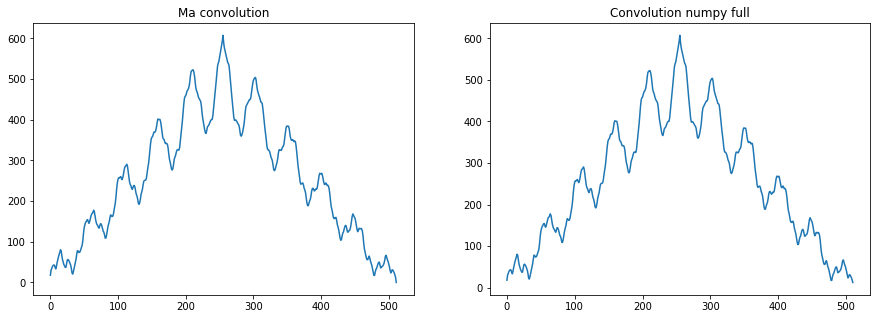

In [ ]:
h = convolution(f, g)
hcheck = np.convolve(f, g, mode='full')
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(h)
plt.title('Ma convolution')
plt.subplot(1, 2, 2)
plt.plot(hcheck)
plt.title('Convolution numpy full')
plt.show()

(7) Un autre moyen de calculer le produit de convolution de deux signaux (cf. cours) est:
1. de calculer la transformée de Fourier de ces signaux
2. de calculer le produit des deux transformées de Fourier
3. de calculer la transformée inverse du produit

Cet algorithme est appelé convolution rapide. Implémenter l'algorithme proposé ci-dessus. Retrouve-t-on le même résultat qu'avec l'algorithme implémenté précédemment? Pourquoi? 

**Réponse**

On obtient un résult totalement différent du précédent en utilisant cette méthode. Cela est entièrement dû aux effets de bord. La transformée de Fourier périodise le signal, de sorte que le produit de convolution qu'on est en train d'évaluer est celui de signaux $\tilde{f}$ et $\tilde{g}$ périodisés de $f$ et $g$, et non pas des signaux $f$ et $g$ proprement dits.


Ce type de convolution est appelé convolution périodique ou circulaire. D'un point de vue mathématique, lorsqu'on évalue les quantités $\tilde{f}[k]$ et $\tilde{g}[n - k]$ pour une convolution circulaire, on a, du fait de la périodisation induite par le passage dans l'espace de Fourier:

$$
\forall k \geq M, \quad \tilde{f}[k] = f[k - M]
$$
et 
$$
\forall k > n, \quad \tilde{g}[n - k] = g[n - k + M]
$$

alors que pour une convolution classique:

$$
\forall k \geq M, \quad f[k] = 0
$$
et 
$$
\forall k > n, \quad g[n - k] = 0
$$

In [ ]:
def fast_circular_convolution(f, g):
    
    """
    Convolution between two signals with same size M computed with 
    the fast Fourier transform algorithm.
    
    :param f: Signal
    :type f: numpy array
    :param g: Second signal
    :type g: numpy array
    
    :return: Convolution between f and g
    :rtype: numpy array
    """
    f_hat = fft(f)
    g_hat = fft(g)
    h_hat = f_hat*g_hat
    h = ifft(h_hat)
    return h

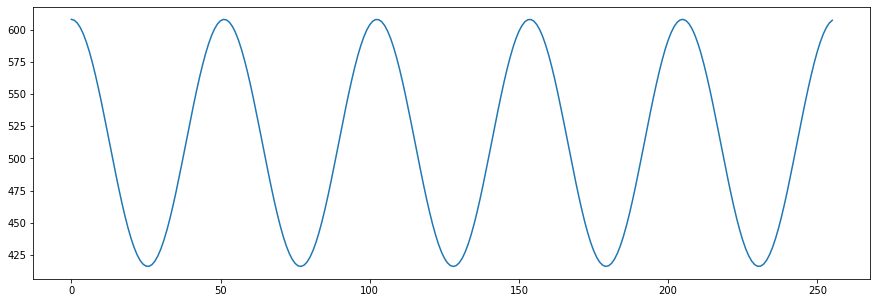

In [ ]:
h = fast_circular_convolution(f, g)
plt.figure(figsize = (15, 5))
plt.plot(h.real)
plt.show()


(8) Afin de remédier au problème de périodisation induit par la transformée de Fourier, une solution simple consiste à ajouter $M$ zéros à la fin des deux signaux $f$ et $g$. Implémenter le nouvel algorithme proposé, et vérifier qu'on retrouve bien les résultats obtenus avec le premier algorithme.

In [ ]:
def fast_convolution(f, g):
    
    """
    Convolution between two signals with same size M computed with 
    the fast Fourier transform algorithm.
    
    :param f: Signal
    :type f: numpy array
    :param g: Second signal
    :type g: numpy array
    
    :return: Convolution between f and g
    :rtype: numpy array
    """   
    M = len(f)
    fpad = np.zeros(2*M)
    gpad = np.zeros(2*M)
    fpad[0:M] = f[:]
    gpad[0:M] = g[:]
    
    h = fast_circular_convolution(fpad, gpad)
    return h

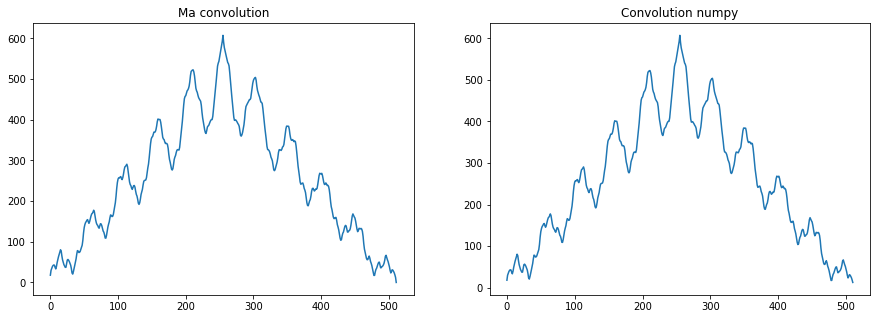

In [ ]:
h = fast_convolution(f, g)
hcheck = np.convolve(f, g, mode='full')#valid
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(h.real)
plt.title('Ma convolution')
plt.subplot(1, 2, 2)
plt.plot(hcheck)
plt.title('Convolution numpy')
plt.show()

(9) Déterminer le nombre d'opérations nécessaires pour le calcul d'une convolution rapide. On supposera pour ce faire que le nombre d'opérations nécessaires pour calculer la transformée de Fourier d'un signal de taille $M$ est $\dfrac{M}{2} \log_2(M)$. Quel algorithme est le plus efficace lorsque $M$ est grand?

**Réponse**

Le coût associé aux transformées de Fourier directe des signaux $f$ et $g$ et à la transformée inverse est de l'ordre de $3M(\log_2(M) + 1)$, auquel on doit ajouter un total de $2M$ multiplications complexes. Pour des valeurs élevées de $M$, le passage par la transformée de Fourier est considérablement plus efficace que le calcul direct.
